# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle

from helper_functions import undistortImage, warpImage, unwarpImage, absSobelThresh, getColorFilter

%matplotlib inline

In [2]:
# RGB range for yellow and white lane lines
yellow_low = np.array([180, 128, 0])
yellow_high = np.array([255, 255, 128])    
white_low = np.array([230, 230, 128])
white_high = np.array([255, 255, 255])

# First n frames to ignore while doing sanity and other checks
first_n_frames = 5

In [3]:
# Load saved parameters
camera_params = pickle.load(open("camera_params.pkl", "rb"))
camera_mtx = camera_params[0]
camera_dist = camera_params[1]

transform_matrix = pickle.load(open("transform_matrix.pkl", "rb"))
M = transform_matrix[0]
Minv = transform_matrix[1]

## Read in an Image

In [4]:
#reading in an image
image = mpimg.imread('test_images/straight_lines1.jpg')
img_size = (image.shape[1], image.shape[0])

#printing out some stats and plotting
#print('This image is:', type(image), 'with dimensions:', image.shape)
#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [27]:
def laneSelectionFilter(image):        
    # Get yellow and white filters
    yellow_filter = getColorFilter(image, yellow_low, yellow_high)
    white_filter = getColorFilter(image, white_low, white_high)
    # Combine yellow and white filters
    lane_color_filter = cv2.bitwise_or(yellow_filter, white_filter)
    
    # Convert image to gray 
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply sobel x filter
    sobel_x = absSobelThresh(gray, 'x', 3, (20,100))    
    
    # Combine Color and Sobel filter
    lane_filter = np.zeros_like(sobel_x)
    lane_filter[(lane_color_filter >= 0.5) | (sobel_x >= 0.5)] = 1
        
    if 1:
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 9))
        #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 9))
        f.tight_layout()
        ax1.imshow(image)
        ax1.set_title('Warped Image', fontsize=20)
        ax1.axis('off')
        ax2.imshow(lane_color_filter)
        ax2.set_title('Yellow-White Color Filter', fontsize=20)
        ax2.axis('off')
        ax3.imshow(sobel_x)
        ax3.set_title('Sobel X Filter', fontsize=20)
        ax3.axis('off')
        ax4.imshow(lane_filter)
        ax4.set_title('Final Filter', fontsize=20)
        ax4.axis('off')
        f.subplots_adjust(hspace=0)
    
    return lane_filter    

In [6]:
def findRadiusOfCurvature(ploty, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    radius_of_curvature = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    return radius_of_curvature

In [7]:
def findCarPosition(left_lane, right_lane):
    # Find value of x at the bottom of the image for both left and right lanes
    y_value = img_size[1]
    image_center = img_size[0]/2
    left_x = left_lane.best_fit[0]*y_value**2 + left_lane.best_fit[1]*y_value + left_lane.best_fit[2]
    right_x = right_lane.best_fit[0]*y_value**2 + right_lane.best_fit[1]*y_value + right_lane.best_fit[2]
    car_center = (left_x + right_x)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (image_center - car_center)*xm_per_pix

In [8]:
def sanityCheck(left_fitx, right_fitx, left_radius_of_curvature, right_radius_of_curvature):
    global frame_number
    sanity_check = True
    lane_width = 3 # This number if found by running through the video 
    xm_per_pix = lane_width/700
    
    # Check for lane width
    diffx = np.subtract(right_fitx, left_fitx)    
    avg_lane_width = np.sum(diffx)/len(diffx)
    avg_lane_width_meters = avg_lane_width*xm_per_pix
    min_lane_width = lane_width - 0.5
    max_lane_width = lane_width + 0.5
    
    # Check if lane width is within a margin of known lane width
    if((avg_lane_width_meters < min_lane_width) | (avg_lane_width_meters > max_lane_width)):
        sanity_check = False
        
    # Check if the left and right radius of curavture agree with each other
    diff_rad = np.abs(left_radius_of_curvature - right_radius_of_curvature)/max(left_radius_of_curvature, right_radius_of_curvature)
    if(diff_rad > 0.7):
        sanity_check &= False
    
    # Don't do sanity check on first few frames
    if(frame_number < first_n_frames):
        sanity_check = True
        
    return sanity_check    

In [9]:
def findLanePixels(lane_filter, lane):    
    #Find the pixel positions from scratch if find_lane is True
    # Otherwise use previous positions to estimate the current pixel positions
    if True == lane.find_lane:
        lane.findLane(lane_filter)
    else:
        lane.estimateLane(lane_filter)
    
    # If no lane pixels are found in the current frame, use previous frame's lane pixels.
    # This makes sure that the video doesnt break in between
    if((0 == lane.allx.size) | (0 == lane.ally.size)):
        allx = lane.prev_allx
        ally = lane.prev_ally
    else:
        allx = lane.allx
        ally = lane.ally
        lane.prev_allx = allx
        lane.prev_ally = ally        
        
    return ally, allx

In [10]:
def generateXValues(fit, ploty):
    # Find x values given polynomial and y values
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    return fitx

## Build Advanced Lane Finding Pipeline



In [11]:
def pipeline(image):
    global frame_number
    
    frame_number += 1
    
    Left_Lane.frame_number = frame_number
    Right_Lane.frame_number = frame_number

    # Undistort the image
    undist = undistortImage(image, camera_mtx, camera_dist)
    
    # Perform perspective transform to get bird's eye view of the lanes
    warped = warpImage(undist, M, img_size)
    
    # Detect lane lines using filtering and thresholding techniques
    lane_filter = laneSelectionFilter(warped)
        
    if 0:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(warped)
        ax1.set_title('Warped Image', fontsize=30)
        ax2.imshow(lane_filter)
        ax2.set_title('Binary Image', fontsize=30)        
        
    # Find lane pixel positions. 
    left_lane_ally, left_lane_allx = findLanePixels(lane_filter, Left_Lane)
    right_lane_ally, right_lane_allx = findLanePixels(lane_filter, Right_Lane)
        
    # Fit a second order polynomial to each lane
    left_current_fit = np.polyfit(left_lane_ally, left_lane_allx, 2)
    right_current_fit = np.polyfit(right_lane_ally, right_lane_allx, 2)    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, lane_filter.shape[0]-1, lane_filter.shape[0])
    left_fitx = generateXValues(left_current_fit, ploty)
    right_fitx = generateXValues(right_current_fit, ploty)
    
    if 0:
        Left_Lane.out_img[left_lane_ally, left_lane_allx] = [255, 0, 0]
        Right_Lane.out_img[right_lane_ally, right_lane_allx] = [0, 0, 255]    
        out_img = np.zeros_like(Left_Lane.out_img)
        out_img = Left_Lane.out_img | Right_Lane.out_img
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    # Compute radius of curvature
    left_radius_of_curvature = findRadiusOfCurvature(ploty, left_fitx)
    right_radius_of_curvature = findRadiusOfCurvature(ploty, right_fitx)    
    
    # Check for plausibility of lane width and radius of curvature for every frame
    check_flag = sanityCheck(left_fitx, right_fitx, left_radius_of_curvature, \
                             right_radius_of_curvature)
    
    if(True == check_flag):
        Left_Lane.updateLaneParameters(left_current_fit, ploty)
        Right_Lane.updateLaneParameters(right_current_fit, ploty)
        Left_Lane.not_detected_age = 0
        Right_Lane.not_detected_age = 0
    else:
        Left_Lane.not_detected_age += 1
        Right_Lane.not_detected_age += 1
    
    # If we see bad frames for consecutive n cycle, the lanes of next frame should be found from scratch
    if(Left_Lane.not_detected_age > (Left_Lane.history_buffer_size-1)):
        Left_Lane.find_lane = True
    if(Right_Lane.not_detected_age > (Right_Lane.history_buffer_size-1)):
        Right_Lane.find_lane = True
        
    # Find position of car from lane center
    car_offset_from_center = findCarPosition(Left_Lane, Right_Lane)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(lane_filter).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([Left_Lane.best_xfitted, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([Right_Lane.best_xfitted, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    final_image = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Print radius of curvature on video
    cv2.putText(final_image, 'Curvature Radius Left:{}(m),'.format(int(Left_Lane.radius_of_curvature)), (80,140),
             fontFace = 16, fontScale = 1.5, color=(255,255,255), thickness = 2)
    cv2.putText(final_image, 'Right:{}(m)'.format(int(Right_Lane.radius_of_curvature)), (850,140),
             fontFace = 16, fontScale = 1.5, color=(255,255,255), thickness = 2)
    cv2.putText(final_image, 'Car offset from center:{}(mm)'.format(int(car_offset_from_center*1000)), (80,220),
             fontFace = 16, fontScale = 1.5, color=(255,255,255), thickness = 2)
    
    #plt.imshow(final_image)    
    
    return final_image

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.find_lane = True
        # was the line detected in the last iteration?
        self.detected = False  
        #size of history buffer
        self.history_buffer_size = 10
        # number of consecutive iterations for which the lane was not detected
        self.not_detected_age = 0  
        # x values for the best fit
        self.best_xfitted = []
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [0, 0, 0]  
        #polynomial coefficients for the most recent good fit
        self.good_fit = [[0,0,0] for i in range(self.history_buffer_size)]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x values for detected line pixels
        self.prev_allx = None  
        #y values for detected line pixels
        self.prev_ally = None
        #number of iterations that passed sanity check
        self.good_iteration = 0
        #index of history buffer
        self.history_buffer_index = 0
        #frame number
        self.frame_number = 0
        #frame number
        self.out_img = 0
        return
    
    def findLane(self, binary_warped):
        if(self.frame_number > first_n_frames):
            self.find_lane = False
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result
        self.out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        #plt.imshow(out_img)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        #print(midpoint)
        if self == Left_Lane:
            x_base = np.argmax(histogram[:midpoint])
        elif self == Right_Lane:
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        x_current = x_base
        # Set the width of the windows +/- margin
        margin = 50
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        lane_inds = []
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(self.out_img,(win_x_low,win_y_low),(win_x_high,win_y_high),
            (0,255,0), 2)
            # Identify the nonzero pixels in x and y within the window
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            # Append these indices to the lists
            lane_inds.append(good_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))
                
        # Concatenate the arrays of indices
        lane_inds = np.concatenate(lane_inds)
        # Extract left and right line pixel positions
        self.allx = nonzerox[lane_inds]
        self.ally = nonzeroy[lane_inds]
        return
        
    def estimateLane(self, binary_warped):
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 50
        fit_index = (self.history_buffer_index-1)%self.history_buffer_size
        fit = self.good_fit[fit_index]
        lane_inds = ((nonzerox > (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] - margin)) & 
                     (nonzerox < (fit[0]*(nonzeroy**2) + fit[1]*nonzeroy + fit[2] + margin)))             
        # Again, extract left and right line pixel positions
        self.allx = nonzerox[lane_inds]
        self.ally = nonzeroy[lane_inds]
        return
        
    def averageLaneFit(self):
        avg_fit = [0, 0, 0]
        good_iteration = self.good_iteration
        history_buffer_size = self.history_buffer_size
        if(good_iteration < history_buffer_size):
            buffer_size = good_iteration
        else:
            buffer_size = history_buffer_size
        for index in range(buffer_size):
            avg_fit = np.add(avg_fit, self.good_fit[index])
        avg_fit = avg_fit/buffer_size
        return avg_fit
    
    def updateLaneParameters(self, current_fit, ploty):
        self.good_iteration += 1
        self.good_fit[self.history_buffer_index] = current_fit
        self.best_fit = self.averageLaneFit()
        self.best_xfitted = generateXValues(self.best_fit, ploty)
        self.radius_of_curvature = findRadiusOfCurvature(ploty, self.best_xfitted)
        self.history_buffer_index = self.good_iteration % self.history_buffer_size
        return
        

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    result = pipeline(image)

    return result

## Test pipeline on an image


array([[[ 84, 138, 185],
        [ 85, 139, 186],
        [ 85, 139, 186],
        ..., 
        [ 72, 130, 178],
        [ 73, 131, 179],
        [ 74, 132, 180]],

       [[ 85, 137, 185],
        [ 86, 138, 186],
        [ 86, 138, 186],
        ..., 
        [ 72, 130, 178],
        [ 73, 131, 179],
        [ 74, 132, 180]],

       [[ 85, 137, 185],
        [ 85, 137, 185],
        [ 86, 138, 186],
        ..., 
        [ 73, 131, 177],
        [ 73, 131, 178],
        [ 73, 131, 177]],

       ..., 
       [[ 95,  83,  99],
        [ 95,  83,  99],
        [ 96,  83,  99],
        ..., 
        [118,  97,  93],
        [116,  96,  91],
        [114,  94,  90]],

       [[ 96,  84,  98],
        [ 96,  84,  98],
        [ 96,  84,  98],
        ..., 
        [116,  95,  90],
        [118,  97,  92],
        [116,  95,  90]],

       [[ 96,  84,  96],
        [ 96,  84,  96],
        [ 97,  85,  97],
        ..., 
        [115,  94,  91],
        [117,  96,  92],
        [116,  95,

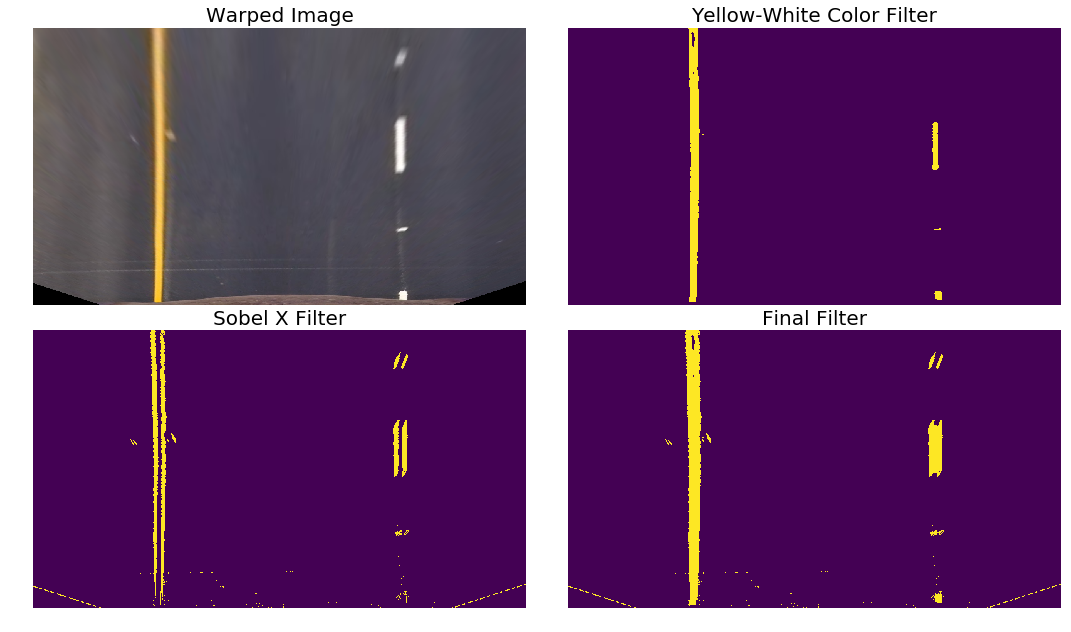

In [28]:
frame_number = 0
Left_Lane = Line()
Right_Lane = Line()
image = mpimg.imread('test_images/straight_lines1.jpg')
process_image(image)

## Test pipeline on video

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
#video_output = 'project_video_output.mp4'
video_output = 'challenge_video_output.mp4'
#video_output = 'harder_challenge_video_output.mp4'


frame_number = 0
Left_Lane = Line()
Right_Lane = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,1)
#clip1 = VideoFileClip("project_video.mp4").subclip(19,28)
#clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("challenge_video.mp4")
#clip1 = VideoFileClip("harder_challenge_video.mp4")
video_frame = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_frame.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:11<00:00,  7.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 13s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.
